#### Headers

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
pd.set_option('display.max_colwidth',-1) # set max col width in order we can some more content
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
import re
import nltk

#### Removing some common abbreviations

In [2]:
punctuation='["\'?,\.]' # I will replace all these punctuation with ''
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    punctuation:'',
    '\s+':' ',
}


In [3]:
data=pd.read_csv("train.csv")
data.question1=data.question1.str.lower() # conver to lower case
data.question2=data.question2.str.lower()
data.question1=data.question1.astype(str)
data.question2=data.question2.astype(str)
data.replace(abbr_dict,regex=True,inplace=True)
display(data.head(2))

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) diamond,what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back,0


#### Class Distribution in training data

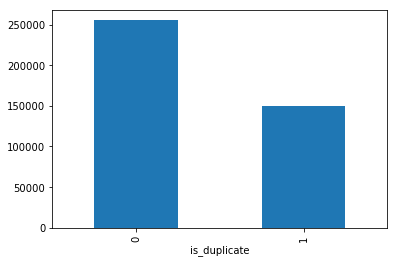

In [9]:
data.groupby("is_duplicate")['id'].count().plot.bar()

Create a dataframe where the top 50% of rows have only question 1 and the bottom 50% have only question 2, same ordering per halve as in the original dataframe.

In [4]:
dfq1, dfq2 = data[['qid1', 'question1']], data[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
print dfqa.shape
del dfq1,dfq2

(808580, 3)


In [5]:
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<808580x256 sparse matrix of type '<type 'numpy.float64'>'
	with 5031821 stored elements in Compressed Sparse Row format>

In [6]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<404290x256 sparse matrix of type '<type 'numpy.float64'>'
	with 4687206 stored elements in Compressed Sparse Row format>

In [7]:
del dfqa

In [8]:
def basic_cleaning(string):
    string = str(string)
    try:
        string = string.decode('unicode-escape')
    except Exception:
        pass
    string = string.lower()
    string = re.sub(' +', ' ', string)
    return string
    #nltk.word_tokenize(basic_cleaning(questions[i])))



#### Get word share from tokenized texts

In [23]:
data['q1len'] = data['question1'].str.len()
data['q2len'] = data['question2'].str.len()

data['q1_n_words'] = data['question1'].apply(lambda row: len(nltk.word_tokenize(basic_cleaning(row))))
data['q2_n_words'] = data['question2'].apply(lambda row: len(nltk.word_tokenize(basic_cleaning(row))))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), nltk.word_tokenize(basic_cleaning(row['question1']))))
    w2 = set(map(lambda word: word.lower().strip(), nltk.word_tokenize(basic_cleaning(row['question2']))))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


data['word_share'] = data.apply(normalized_word_share, axis=1)

data.head()



,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,how does the surface pro himself 4 compare with ipad pro,why did microsoft choose core m3 and not core i3 home surface pro 4,56,67,11,14,0.130435
1,1,should i have a hair transplant at age 24 how much would it cost,how much cost does hair transplant require,64,42,14,7,0.238095
2,2,what but is the best way to send money from china to the us,what you send money to china,59,28,14,6,0.277778
3,3,which food not emulsifiers,what foods fibre,26,16,4,3,0.000000
4,4,how aberystwyth start reading,how their can i start reading,29,29,4,6,0.300000


In [33]:
set(data['word_share'])

{0.0,
 0.017857142857142856,
 0.018181818181818181,
 0.018518518518518517,
 0.019230769230769232,
 0.019607843137254902,
 0.02,
 0.020408163265306121,
 0.020833333333333332,
 0.021276595744680851,
 0.021739130434782608,
 0.022222222222222223,
 0.022727272727272728,
 0.023255813953488372,
 0.023809523809523808,
 0.024390243902439025,
 0.025000000000000001,
 0.02564102564102564,
 0.026315789473684209,
 0.027027027027027029,
 0.027777777777777776,
 0.028571428571428571,
 0.029411764705882353,
 0.030303030303030304,
 0.03125,
 0.032258064516129031,
 0.033333333333333333,
 0.033898305084745763,
 0.034482758620689655,
 0.035087719298245612,
 0.035714285714285712,
 0.037037037037037035,
 0.037735849056603772,
 0.038461538461538464,
 0.039215686274509803,
 0.040000000000000001,
 0.040816326530612242,
 0.041666666666666664,
 0.042553191489361701,
 0.043478260869565216,
 0.044444444444444446,
 0.045454545454545456,
 0.046511627906976744,
 0.047244094488188976,
 0.047619047619047616,
 0.048387096

#### Extract unique questions

In [24]:
data.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,how does the surface pro himself 4 compare with ipad pro,why did microsoft choose core m3 and not core i3 home surface pro 4,56,67,11,14,0.130435
1,1,should i have a hair transplant at age 24 how much would it cost,how much cost does hair transplant require,64,42,14,7,0.238095
2,2,what but is the best way to send money from china to the us,what you send money to china,59,28,14,6,0.277778
3,3,which food not emulsifiers,what foods fibre,26,16,4,3,0.000000
4,4,how aberystwyth start reading,how their can i start reading,29,29,4,6,0.300000


In [25]:
questions = dict()
i = 0
for row in data.iterrows():
    #questions[row[1]['qid1']] = row[1]['question1']
    #questions[row[1]['qid2']] = row[1]['question2']
    questions[i] = row[1]['question1']
    questions[i+1] = row[1]['question2']
    i += 2


In [26]:
sentences = []
for i in questions:
    sentences.append(nltk.word_tokenize(basic_cleaning(questions[i])))

In [27]:
import gensim
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [28]:
tf = dict()
docf = dict()
total_docs = 0
for qid in questions:
    total_docs += 1
    toks = nltk.word_tokenize(basic_cleaning(questions[qid]))
    uniq_toks = set(toks)
    for i in toks:
        if i not in tf:
            tf[i] = 1
        else:
            tf[i] += 1
    for i in uniq_toks:
        if i not in docf:
            docf[i] = 1
        else:
            docf[i] += 1


In [29]:
from __future__ import division
import math
def idf(word):
    return 1 - math.sqrt(docf[word]/total_docs)

In [30]:
import re
import nltk
def basic_cleaning2(string):
    string = str(string)
    string = string.lower()
    string = re.sub('[0-9\(\)\!\^\%\$\'\"\.;,-\?\{\}\[\]\\/]', ' ', string)
    string = ' '.join([i for i in string.split() if i not in ["a", "and", "of", "the", "to", "on", "in", "at", "is"]])
    string = re.sub(' +', ' ', string)
    return string

In [31]:
def w2v_sim(w1, w2):
    try:
        return model.similarity(w1, w2)*idf(w1)*idf(w2)
    except Exception:
        return 0.0

In [32]:
def img_feature(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = nltk.word_tokenize(basic_cleaning2(s1))
    t2 = nltk.word_tokenize(basic_cleaning2(s1))
    Z = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(Z, order='C')
    return [np.resize(a,(10,10)).flatten()]


img = data.apply(img_feature, axis=1, raw=True)
pix_col = [[] for y in range(100)] 
for k in img.iteritems():
        for f in range(len(list(k[1][0]))):
               pix_col[f].append(k[1][0][f])


In [33]:
for g in range(len(pix_col)):
    data['img'+str(g)] = pix_col[g]


In [51]:
list(data.columns)

['id',
 'qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_share',
 'img0',
 'img1',
 'img2',
 'img3',
 'img4',
 'img5',
 'img6',
 'img7',
 'img8',
 'img9',
 'img10',
 'img11',
 'img12',
 'img13',
 'img14',
 'img15',
 'img16',
 'img17',
 'img18',
 'img19',
 'img20',
 'img21',
 'img22',
 'img23',
 'img24',
 'img25',
 'img26',
 'img27',
 'img28',
 'img29',
 'img30',
 'img31',
 'img32',
 'img33',
 'img34',
 'img35',
 'img36',
 'img37',
 'img38',
 'img39',
 'img40',
 'img41',
 'img42',
 'img43',
 'img44',
 'img45',
 'img46',
 'img47',
 'img48',
 'img49',
 'img50',
 'img51',
 'img52',
 'img53',
 'img54',
 'img55',
 'img56',
 'img57',
 'img58',
 'img59',
 'img60',
 'img61',
 'img62',
 'img63',
 'img64',
 'img65',
 'img66',
 'img67',
 'img68',
 'img69',
 'img70',
 'img71',
 'img72',
 'img73',
 'img74',
 'img75',
 'img76',
 'img77',
 'img78',
 'img79',
 'img80',
 'img81',
 'img82',
 'img83',
 'img84',
 'img85',
 'img86',
 'img

In [19]:
x_train = data[list(data.columns)[6:]]
y_train = data['is_duplicate'].values

In [20]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

/home/submukhe/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [21]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.01
params['max_depth'] = 6

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.690597	valid-logloss:0.690593
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.667329	valid-logloss:0.667313
[20]	train-logloss:0.647644	valid-logloss:0.647693
[30]	train-logloss:0.631035	valid-logloss:0.631175
[40]	train-logloss:0.616753	valid-logloss:0.616976
[50]	train-logloss:0.604491	valid-logloss:0.604797
[60]	train-logloss:0.593895	valid-logloss:0.594317
[70]	train-logloss:0.584621	valid-logloss:0.585175
[80]	train-logloss:0.576454	valid-logloss:0.577126
[90]	train-logloss:0.569325	valid-logloss:0.570085
[100]	train-logloss:0.563031	valid-logloss:0.563896
[110]	train-logloss:0.557442	valid-logloss:0.558409
[120]	train-logloss:0.552494	valid-logloss:0.553584
[130]	train-logloss:0.548143	valid-logloss:0.549351
[140]	train-logloss:0.54421	valid-logloss:0.54553
[150]	train-logloss:0.540753	valid-logloss:0.542175
[160]	train-logloss:0.537524	

In [22]:
data=pd.read_csv("test.csv")
data.question1=data.question1.str.lower() # conver to lower case
data.question2=data.question2.str.lower()
data.question1=data.question1.astype(str)
data.question2=data.question2.astype(str)
data.replace(abbr_dict,regex=True,inplace=True)
display(data.head(2))

,test_id,question1,question2
0,0,how does the surface pro himself 4 compare with ipad pro,why did microsoft choose core m3 and not core i3 home surface pro 4
1,1,should i have a hair transplant at age 24 how much would it cost,how much cost does hair transplant require


In [34]:
print 'hello'

hello


In [35]:
data.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share,img0,img1,...,img90,img91,img92,img93,img94,img95,img96,img97,img98,img99
0,0,how does the surface pro himself 4 compare with ipad pro,why did microsoft choose core m3 and not core i3 home surface pro 4,56,67,11,14,0.130435,0.240464,-0.009752,...,-0.009752,0.557387,0.013105,0.024266,0.125095,-0.075199,-0.000958,-0.002864,0.024266,0.065452
1,1,should i have a hair transplant at age 24 how much would it cost,how much cost does hair transplant require,64,42,14,7,0.238095,0.614900,0.067579,...,-0.053298,0.084051,0.036694,-0.005305,0.059305,-0.071180,0.707389,0.077598,-0.120328,0.060747
2,2,what but is the best way to send money from china to the us,what you send money to china,59,28,14,6,0.277778,0.147033,0.025627,...,0.025627,0.787127,-0.107031,0.000436,0.049498,0.077199,-0.003053,0.119969,0.159985,0.070750
3,3,which food not emulsifiers,what foods fibre,26,16,4,3,0.000000,0.574430,0.170979,...,0.641204,-0.053816,0.107795,0.277207,-0.053816,0.996197,0.574430,0.170979,-0.024078,0.107795
4,4,how aberystwyth start reading,how their can i start reading,29,29,4,6,0.300000,0.240464,-0.009569,...,0.798514,-0.030361,0.091937,-0.074821,-0.030361,0.915943,0.240464,-0.009569,-0.021874,0.091937


In [38]:
data.columns

Index([u'test_id', u'question1', u'question2', u'q1len', u'q2len',
       u'q1_n_words', u'q2_n_words', u'word_share', u'img0', u'img1',
       ...
       u'img90', u'img91', u'img92', u'img93', u'img94', u'img95', u'img96',
       u'img97', u'img98', u'img99'],
      dtype='object', length=108)

In [ ]:
data['is_duplicate'] = bst.predict(xgb.DMatrix(data[list(data.columns)[3:]]))